In [1]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import sys
sys.path.append('../../local/bin/')

In [3]:
from sygno.signed_networkx import draw_signed_networkx

In [4]:
def draw_graph(df, pol_dic, congress_num):
    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.icpsr)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0],  'congress': list(g.congress)[0], 'name': list(g.bioname)[0]} for k, g in pol.groupby('icpsr')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3,sort_by='party');
    
    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[int(p)]['party_name'] == 'Democrat' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[int(p)]['party_name']] += 1
        else:
            if pol_dic[int(p)]['party_name'] == 'party_name' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[int(p)]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

In [5]:
dataset_folder = '../../dataset/'

In [6]:
pol = pd.read_csv(dataset_folder + 'members.csv')

pol['color'] = pol['party_name'].apply(lambda x: 'firebrick' if 'Republican' in x else ('royalblue' if 'Democrat' in x else 'yellow'))

In [7]:
pol_dic = pol[['icpsr', 'party_name']].set_index('icpsr').to_dict(orient="index")
pol.head()

,icpsr,congress,party_code,bioname,state_abbrev,party_name,color
0,1,[82],[200],"AANDAHL, Fred George",ND,['Republican'],firebrick
1,2,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[100],"ABBITT, Watkins Moorman",VA,['Democrat'],royalblue
2,3,"[28, 29, 30]",[29],"ABBOTT, Amos",MA,['Whig'],yellow
3,4,"[50, 51, 52, 53, 54]",[100],"ABBOTT, Jo (Joseph)",TX,['Democrat'],royalblue
4,5,"[15, 16, 17, 18]","[7777, 13]","ABBOT, Joel",GA,"['Crawford Republican', 'Democrat-Republican']",firebrick


In [8]:
pol_dic[8024]

{'party_name': "['Republican']"}

In [9]:
def read_edgelist(folder, threshold_pos, threshold_neg, congress_num):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])

    draw_graph(df, pol_dic, congress_num)

Example on topic specific edgelist

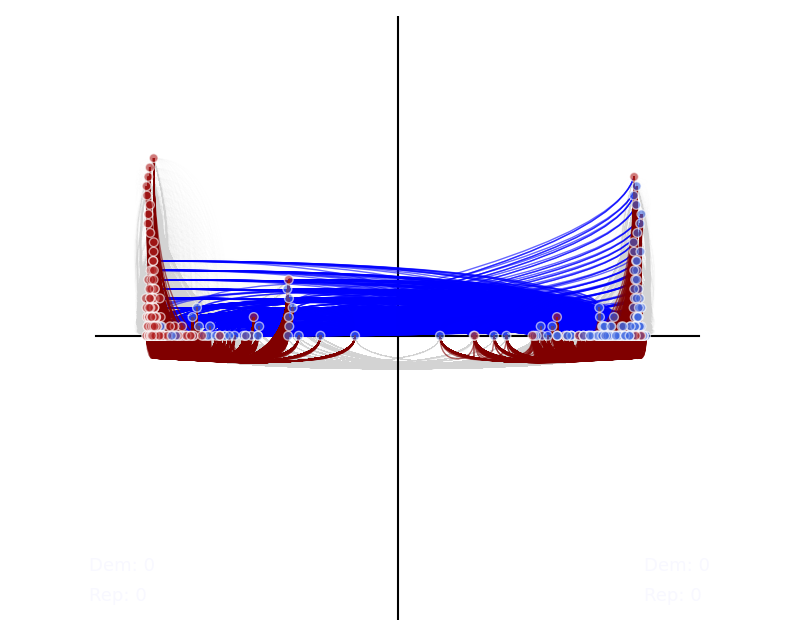

In [13]:
cong = '78'
temp = pd.read_csv('../../dataset/thresholds/house_clausen_thresholds/Civil_Liberties/'+cong+'_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

read_edgelist('../../dataset/edgelists/votes_house_clausen_edges/Civil_Liberties/congress_'+cong+'.csv', threshold_pos, threshold_neg, cong)

#### Compute normalized least eigenvalue

In [14]:
from sygno.nodes_position import _get_xcoord

In [15]:
def compute_eigen(df):
    def compute_d_max(G):
        max_d = 0
        for edge in G.edges(data=True):
            temp = G.degree[edge[0]] + G.degree[edge[1]]
            if temp > max_d:
                max_d = temp
        return max_d / 2

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])
    df, least_eigenvalue = _get_xcoord(G, compact=False)
    max_d = compute_d_max(G)
    eig = 1-(least_eigenvalue/(max_d-1))
    return eig

In [16]:
def read_edgelist_eigen(folder, threshold_pos, threshold_neg, congress_num):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])

    return compute_eigen(df)

In [19]:
cong = '79'
temp = pd.read_csv('../../dataset/thresholds/house_clausen_thresholds/Civil_Liberties/'+cong+'_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

eig = read_edgelist_eigen('../../dataset/edgelists/votes_house_clausen_edges/Civil_Liberties/congress_'+cong+'.csv', threshold_pos, threshold_neg, cong)

Exception: Bad input: network G must be connected and undirected.